In [14]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


In [2]:

# --- Fixed Heston params: kappa, theta, sigma, rho, r, K
κ, θ, σ, ρ, r, K = 2.0, 0.04, 0.3, -0.7, 0.03, 100

# --- Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Synthesize Collocation, Boundary, Initial Points
N_col, N_bdy, N_ic = 10000, 1000, 2000
S_lo, S_hi = 0.0, 200.0
v_lo, v_hi = 0.01, 0.5

# Collocation (interior)
t_col = np.random.uniform(0.01, 1.0, N_col)
S_col = np.random.uniform(S_lo, S_hi, N_col)
v_col = np.random.uniform(v_lo, v_hi, N_col)
X_col = np.stack([t_col, S_col, v_col], axis=1)

# Initial (payoff) at t=0
t_ic = np.zeros(N_ic)
S_ic = np.random.uniform(S_lo, S_hi, N_ic)
v_ic = np.random.uniform(v_lo, v_hi, N_ic)
X_ic = np.stack([t_ic, S_ic, v_ic], axis=1)
payoff_ic = np.maximum(S_ic - K, 0)

# Boundary: S=0, S=200, v=0.01, v=0.5 for random t
tb = np.random.uniform(0, 1, N_bdy)
# S boundaries
X_bS0 = np.stack([tb, np.full(N_bdy, S_lo), np.random.uniform(v_lo, v_hi, N_bdy)], axis=1)
X_bSmax = np.stack([tb, np.full(N_bdy, S_hi), np.random.uniform(v_lo, v_hi, N_bdy)], axis=1)
# v boundaries
X_bv0 = np.stack([tb, np.random.uniform(S_lo, S_hi, N_bdy), np.full(N_bdy, v_lo)], axis=1)
X_bvmax = np.stack([tb, np.random.uniform(S_lo, S_hi, N_bdy), np.full(N_bdy, v_hi)], axis=1)

# Concatenate all boundary points
X_bdy = np.concatenate([X_bS0, X_bSmax, X_bv0, X_bvmax], axis=0)


In [3]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1), nn.ReLU()
        )
    def forward(self, x):
        return self.seq(x)



def heston_pde_res(model, X):
    X = X.clone().detach().requires_grad_(True)
    t, S, v = X[:, :1], X[:, 1:2], X[:, 2:3]

    V = model(X)
    grad_ = torch.autograd.grad(V,X, grad_outputs=torch.ones_like(V), create_graph=True, retain_graph=True)[0]  # grad_ shape: (N, D)


    V_t =grad_[:, 0:1]
    V_S = grad_[:, 1:2]
    V_v = grad_[:, 2:3]

    V_S_ = torch.autograd.grad(V_S, X, grad_outputs=torch.ones_like(V_S), create_graph=True, retain_graph=True)[0]
    V_SS=V_S_[:,1:2]
    
    V_Sv=V_S_[:,2:3]
    
    V_vv=torch.autograd.grad(V_v, X, grad_outputs=torch.ones_like(V_v), create_graph=True, retain_graph=True)[0][:,2:3]


    res = (V_t + r*S*V_S + κ*(θ-v)*V_v + 0.5*v*S**2*V_SS +
           ρ*σ*v*S*V_Sv + 0.5*σ**2*v*V_vv - r*V)
    return torch.mean(res**2)




def boundary_loss(model, X):
    X_ = torch.tensor(X, dtype=torch.float32, device=device)
    t, S, v = X_[:,0], X_[:,1], X_[:,2]
    V = model(X_)
    loss = 0.0
    # S=0 call is zero, S=max call is S-K*exp(-rt)
    mask_S0 = (S == S_lo)
    loss += torch.mean(V[mask_S0]**2)
    mask_Smax = (S == S_hi)
    exact = S[mask_Smax:mask_Smax+1] - K * torch.exp(-r*t[mask_Smax:mask_Smax+1])
    loss += torch.mean((V[mask_Smax] - exact)**2)
    # v boundaries: no-arbitrage, can be soft (set option as Black-Scholes approx or just zero)
    return loss



def init_loss(model, X, payoff):
    X_ = torch.tensor(X, dtype=torch.float32, device=device)
    pf = torch.tensor(payoff, dtype=torch.float32, device=device).unsqueeze(1)
    pred = model(X_)
    return torch.mean((pred - pf)**2)


In [4]:
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)
loss_hist = []



for epoch in range(20000):
    i_col = np.random.choice(len(X_col), 1024)
    i_ic = np.random.choice(len(X_ic), 256)
    i_bdy = np.random.choice(len(X_bdy), 256)
    Xc_b, Xi_b, Xb_b = (torch.tensor(X_col[i_col], dtype=torch.float32, device=device),
                        torch.tensor(X_ic[i_ic], dtype=torch.float32, device=device),
                        torch.tensor(X_bdy[i_bdy], dtype=torch.float32, device=device))
    pf_chunk = torch.tensor(payoff_ic[i_ic], dtype=torch.float32, device=device)
    optimizer.zero_grad()
    loss = heston_pde_res(model, Xc_b) + init_loss(model, Xi_b.cpu().numpy(), pf_chunk.cpu().numpy())
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())
    if epoch % 250 == 0 or epoch == 1999:
        print(f'Epoch {epoch}: loss = {loss.item():.6f}')



Epoch 0: loss = 1392.868652
Epoch 250: loss = 730.261719
Epoch 500: loss = 253.363098
Epoch 750: loss = 147.379089
Epoch 1000: loss = 85.460030
Epoch 1250: loss = 57.707184
Epoch 1500: loss = 34.969833
Epoch 1750: loss = 19.711054
Epoch 1999: loss = 38.969620
Epoch 2000: loss = 32.940594
Epoch 2250: loss = 7.901390
Epoch 2500: loss = 7.802355
Epoch 2750: loss = 8.064693
Epoch 3000: loss = 1.116341
Epoch 3250: loss = 1.365987
Epoch 3500: loss = 0.688695
Epoch 3750: loss = 0.420588
Epoch 4000: loss = 0.408008
Epoch 4250: loss = 0.277832
Epoch 4500: loss = 0.794385
Epoch 4750: loss = 0.488892
Epoch 5000: loss = 0.191739
Epoch 5250: loss = 2.019839
Epoch 5500: loss = 4.439212
Epoch 5750: loss = 0.618677
Epoch 6000: loss = 0.265748
Epoch 6250: loss = 0.175568
Epoch 6500: loss = 0.095751
Epoch 6750: loss = 0.283008
Epoch 7000: loss = 0.484315
Epoch 7250: loss = 0.254347
Epoch 7500: loss = 0.185377
Epoch 7750: loss = 0.292091
Epoch 8000: loss = 0.811945
Epoch 8250: loss = 0.098198
Epoch 8500:

In [12]:
print(" The loss is ", (heston_pde_res(model, Xc_b) + init_loss(model, Xi_b.cpu().numpy(), pf_chunk.cpu().numpy())).item())

 The loss is  0.06752322614192963


In [21]:
# Generate 1000 test points in-sample
N_test = 1000
np.random.seed(124)
test_pts = np.column_stack([
    np.random.uniform(0.01, 1.0, N_test),        # t
    np.random.uniform(0.0, 200.0, N_test),       # S
    np.random.uniform(0.01, 0.5, N_test)         # v
])

# Model inference (with model.eval())
model.eval()
with torch.no_grad():
    X_test = torch.tensor(test_pts, dtype=torch.float32, device=device)
    pinn_prices = model(X_test).cpu().numpy().flatten()

# Monte Carlo reference calculation
def heston_mc(S0, K, T, r, κ, θ, σ, ρ, v0, n_paths=10000, dt=0.01):
    if T <= 0: return max(S0 - K, 0)
    n_steps = int(T/dt)
    S = np.full(n_paths, S0)
    v = np.full(n_paths, v0)
    for _ in range(n_steps):
        Z1, Z2 = np.random.normal(size=n_paths), np.random.normal(size=n_paths)
        W1 = Z1
        W2 = ρ*Z1 + np.sqrt(1-ρ**2)*Z2
        v = np.maximum(v + κ*(θ-v)*dt + σ*np.sqrt(np.maximum(v,0))*np.sqrt(dt)*W2, 1e-8)
        S *= np.exp((r - 0.5*v)*dt + np.sqrt(v*dt)*W1)
    payoff = np.maximum(S-K, 0)
    return np.exp(-r*T)*np.mean(payoff)




Mean Absolute Error: 2.4049
RMSE: 3.7527
Max Absolute Error: 11.5998
R² Score: 0.9817



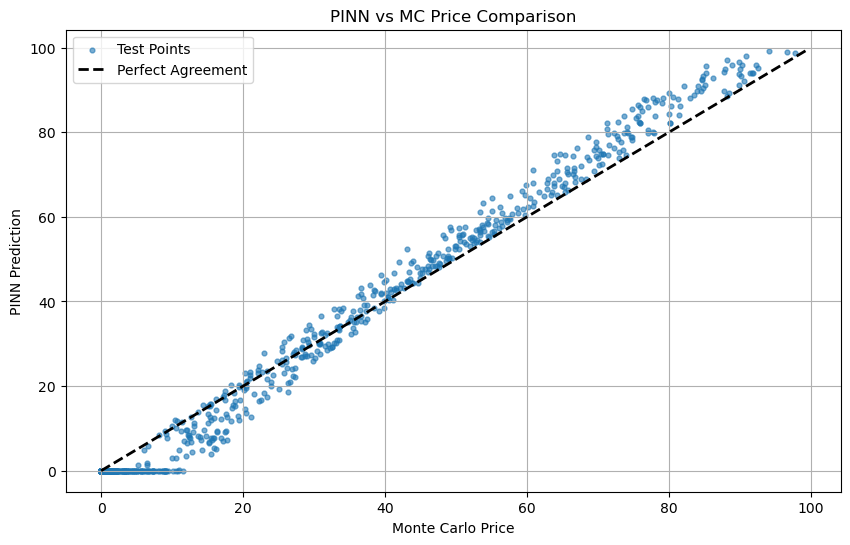

In [22]:
mc_prices = np.array([heston_mc(S, K, t, r, κ, θ, σ, ρ, v) for t, S, v in test_pts])

# Metrics
abs_err = np.abs(pinn_prices - mc_prices)
rel_err = abs_err / (np.abs(mc_prices) + 1e-8)
mae = np.mean(abs_err)
rmse = np.sqrt(np.mean((pinn_prices - mc_prices)**2))
max_ae = np.max(abs_err)
r2 = r2_score(mc_prices, pinn_prices)


print(f"""
Mean Absolute Error: {mae:.4f}
RMSE: {rmse:.4f}
Max Absolute Error: {max_ae:.4f}
R² Score: {r2:.4f}
""")

# Plot comparison and error statistics
plt.figure(figsize=(10,6))
plt.scatter(mc_prices, pinn_prices, s=12, alpha=0.6, label='Test Points')
max_val = max(np.max(mc_prices), np.max(pinn_prices))
plt.plot([0, max_val], [0, max_val], 'k--', lw=2, label='Perfect Agreement')
plt.xlabel('Monte Carlo Price')
plt.ylabel('PINN Prediction')
plt.title('PINN vs MC Price Comparison')
plt.legend()
plt.grid(True)
plt.show()
